In [1]:
# import libraries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import MapboxTiles
import geopandas as gpd
import os
from dotenv import load_dotenv
import pandas as pd
load_dotenv() # loads .env file from main folder for Mapbox API key and local project path
import random

In [2]:
# load parcel and building data

df_parcels = gpd.read_file("./data/Parcels_2020.geojson")
# This is a WGS 84 projection.... 
df_buildings = gpd.read_file("./data/structures_poly_35/structures_poly_35.shp") 

#### Should add functions that checks the type of datafile (geojson or shp)
and search for epsg accordingly

In [3]:
epsg_buildings = df_buildings.crs.to_epsg()

In [5]:
# set parcels CRS to buildings epsg
df_buildings = df_buildings.to_crs(epsg=epsg_buildings)
df_parcels = df_parcels.to_crs(epsg=epsg_buildings)

In [6]:
# set random RGB color for the parcels
def random_hex_color(seed=False):
  if seed:
    random.seed(seed)
    r = random.randint(0, 255)
    random.seed(seed+1000)
    g = random.randint(0, 255)
    random.seed(seed+2000)
    b = random.randint(0, 255)
  else:
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
  return "#{:02x}{:02x}{:02x}".format(r, g, b)
random_hex_color()
df_parcels['color'] = [ random_hex_color() for i in range(len(df_parcels)) ]

In [7]:
# remove duplicates in parcels
indexes_to_remove = []
my_dict = {}
for index, row in df_parcels.iterrows():
    if row['geometry'] not in my_dict:
        my_dict[row['geometry']] = 1
    else:
        indexes_to_remove.append(index)
df_parcels = df_parcels.drop(indexes_to_remove)
df_parcels.reset_index(drop=True, inplace=True)

In [8]:
# remove duplicates in buildings
indexes_to_remove = []
my_dict = {}
for index, row in df_buildings.iterrows():
    if row['geometry'] not in my_dict:
        my_dict[row['geometry']] = 1
    else:
        indexes_to_remove.append(index)
df_buildings = df_buildings.drop(indexes_to_remove)
df_buildings.reset_index(drop=True, inplace=True)

In [9]:
# add building id
df_buildings['building_id'] = [i for i in range(len(df_buildings))]

# add parcel id
df_parcels['parcel_id'] = [i for i in range(len(df_parcels))]

In [10]:
# Perform a spatial join between buildings and parcels
buildings_with_parcel_info = df_buildings.sjoin(df_parcels, how="inner")

In [10]:
#Check how many building there are in each parcel. F.ex. parcel with parcel_id 181422 has 273 building in it!
buildings_with_parcel_info['parcel_id'].value_counts()

parcel_id
91537    278
5934     142
32734    140
89286    133
91702    130
        ... 
25653      1
19321      1
35707      1
80138      1
90288      1
Name: count, Length: 90453, dtype: int64

In [11]:
# Count the number of times each building appears (number of intersecting parcels)
building_counts = buildings_with_parcel_info.groupby("building_id").size()
buildings_with_multiple_parcels = building_counts[building_counts > 1].index.tolist()

# Calculate the percentage of buildings with multiple parcels
percentage_buildings_with_multiple_parcels = (len(buildings_with_multiple_parcels) / len(buildings_with_parcel_info)) * 100

print(f"Percentage of buildings with multiple parcels: {percentage_buildings_with_multiple_parcels:.2f}%")  # 10.47% after deleting parcel duplicates

Percentage of buildings with multiple parcels: 19.27%


<Axes: >

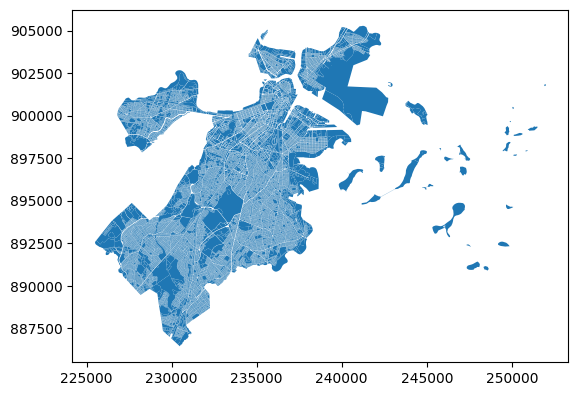

In [12]:
df_parcels.plot()

In [13]:
# All buildings in parcels
len(buildings_with_parcel_info)

163200

<Axes: >

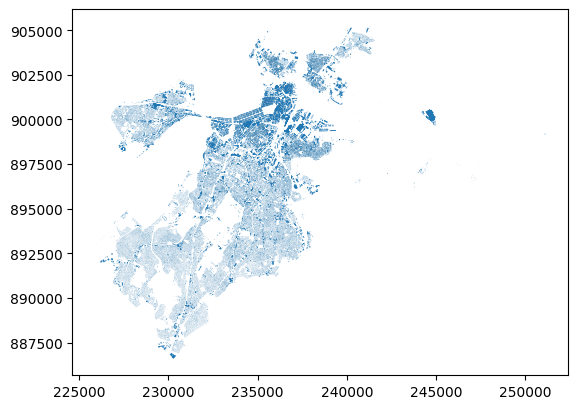

In [14]:
buildings_with_parcel_info.plot()

In [15]:
## For Charlotte dataset: An example of a building with multiple parcels 
#buildings_with_parcel_info[buildings_with_parcel_info['building_id']==29]

In [16]:
# Visualize all parcels associated with a building id
def plot_building_parcels(df, building_id):
    
    parcel_ids = df[df["building_id"] == building_id]["parcel_id"].tolist()
    
    if building_id not in df['building_id']: 
        raise Exception("Building not in list")
     
    # Plot the two cells
    fig, ax = plt.subplots()
    plt.title(f"{building_id}")
    
    # Parcels plot
    df_parcels[ df_parcels['parcel_id'].isin(parcel_ids) ].plot(ax=ax, color="blue")
    
     # Building plot
    df[df['building_id']==building_id].plot(ax=ax, color="red")

    # Show the plot
    plt.show()

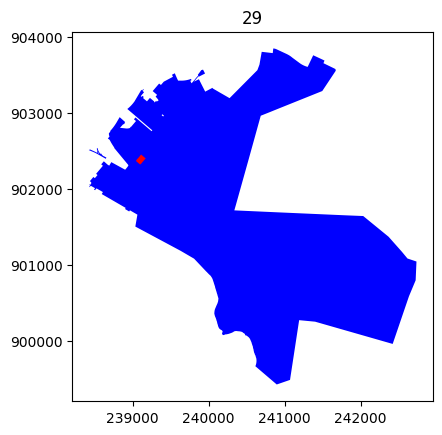

In [17]:
plot_building_parcels(buildings_with_parcel_info, 29)

In [18]:
# Create an empty dictionary to store the maximum area of each building within its parcels
building_max_area_in_parcel = {}

# Iterate through buildings with multiple parcels
for building_id in buildings_with_multiple_parcels:
    
    # Initialize the maximum area for the current building to -1
    building_max_area_in_parcel[building_id] = -1
    
    # Extract information about the current building
    building = df_buildings[df_buildings["building_id"] == building_id].copy()
    
    # Get a list of parcel IDs associated with the current building
    parcel_ids = buildings_with_parcel_info[buildings_with_parcel_info["building_id"] == building_id]["parcel_id"].tolist()
    
    # Initialize variables for iteration
    i = 0
    split_geometries = []
    areas = []
    
    # Split the building geometry into separate parts based on the parcels
    for parcel_id in parcel_ids:
        split_geometries.append(df_parcels[df_parcels["parcel_id"] == parcel_id].geometry.intersection(building.geometry.unary_union))
        areas.append(split_geometries[i].area.values[0])
        i += 1
        
    # Calculate the (area in parcel)/(total area) ratio for each parcel
    areas_normalized = [a/sum(areas) for a in areas]
    
    # Initialize a flag to track if any areas are found
    flag = False
    
    # Find the maximum area within the parcels for the current building
    for a in areas_normalized:
        building_max_area_in_parcel[building_id] = max(building_max_area_in_parcel[building_id], a)


In [19]:
#Set high threshold
threshold = 0.75

In [20]:
# Count how many values are above high threshold
count_above = sum(value > threshold for value in building_max_area_in_parcel.values())
# Calculate the total number of values
total_values = len(building_max_area_in_parcel)
# Calculate the percentage
percentage = (count_above / total_values) * 100
print(count_above,"in", total_values, "buildings above", threshold*100, "%")
print("Percentage: ", percentage)

28323 in 31441 buildings above 75.0 %
Percentage:  90.08301262682484


In [21]:
# Visualize % or building area in parcel, for all buildings

def plot_value_distribution(dictionary):
    # Extract values from the dictionary
    values = list(dictionary.values())
    
    # Plot histogram
    plt.hist(values, bins='auto')  # The 'auto' binning option will attempt to choose a sensible number of bins.
    plt.title('Value Distribution')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

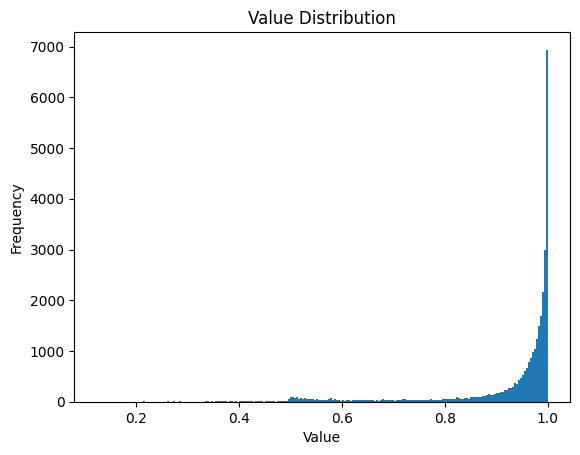

In [22]:
plot_value_distribution(building_max_area_in_parcel)

In [23]:
# Visualize parcels for multiple building ids for comparison

def plot_multiple_building_parcels(df, building_ids, area_perc_dict):
    # Determine the size of the grid
    num_buildings = len(building_ids)
    nrows = int(num_buildings**0.5)  # Take the square root of the number of buildings to get the grid size
    ncols = int(num_buildings / nrows) + (num_buildings % nrows > 0)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))  # Adjust the figsize accordingly
    axs = axs.flatten()  # Flatten the array of axes to make it easier to iterate over

    for index, building_id in enumerate(building_ids):
        ax = axs[index]
        if building_id not in df['building_id'].values:
            raise Exception(f"Building ID {building_id} not in list")
        
        # Get parcel ids after checking if building_id exists in df
        parcel_ids = df[df["building_id"] == building_id]["parcel_id"].tolist()
        
        # Calculate percentage
        perc = round(round(float(area_perc_dict[building_id]), 4) * 100, 2)
        
        # Generate a random color
        random_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        
        # Set title with the building_id and its percentage
        ax.set_title(f"Build. {building_id}: maxArea in parcel {perc}%")
        
        # Plot each parcel with a random color
        for parcel_id in parcel_ids:
            random_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
            df_parcels[df_parcels['parcel_id'] == parcel_id].plot(ax=ax, color=random_color)
        
        # Building plot
        df[df['building_id'] == building_id].plot(ax=ax, color="red")
    
    # Hide any unused subplots
    for ax in axs[num_buildings:]:
        ax.set_visible(False)

    # Adjust the layout
    plt.tight_layout()
    plt.show()


In [24]:
# plot_multiple_building_parcels(buildings_with_parcel_info, [31, 624, 153781, 166903, 1503, 167487, 167141, 457], building_max_area_in_parcel)

In [26]:
# Split buildings according to parcel inclusion

# Create an empty GeoDataFrame to hold the split buildings
split_buildings = gpd.GeoDataFrame()

# Initialize a counter for tracking progress
count = 0

# Create a dictionary to store information about parcels to be removed
to_remove = {}

# Iterate through buildings with multiple parcels
for building_id in buildings_with_multiple_parcels:
    # Print progress every 1000 buildings
    if count % 1000 == 0:
        print(count)
    
    # Increment the counter
    count += 1
    
    # Select the building with the current building_id
    building = df_buildings[df_buildings["building_id"] == building_id].copy()
    
    # Get the list of parcel IDs that intersect with the building
    parcel_ids = buildings_with_parcel_info[buildings_with_parcel_info["building_id"] == building_id]["parcel_id"].tolist()

    # Initialize lists to store split geometries and areas
    split_geometries = []
    areas = []
    
    # Split the building geometry into separate parts based on the parcels
    i = 0
    for parcel_id in parcel_ids:
        split_geometries.append(df_parcels[df_parcels["parcel_id"] == parcel_id].geometry.intersection(building.geometry.unary_union)) 
        areas.append(split_geometries[i].area.values[0])
        i += 1
        
    # Calculate the normalized areas for each parcel
    areas_normalized = [a/sum(areas) for a in areas]
    
    # Find the maximum normalized area value and its index
    max_value = max(areas_normalized)
    max_index = areas_normalized.index(max_value)
    
    # If the maximum area is greater than or equal to 0.75, remove everything except the one with high area
    if max_value >= 0.75:
        to_remove[building_id] = parcel_ids[:max_index] + parcel_ids[max_index + 1:]
    else:
        # If the maximum area is less than 0.75, remove all parcels below 0.15 and between 0.15 and 0.75
        for i in range(len(areas_normalized)):
            if areas_normalized[i] <= 0.15:
                if building_id in to_remove:
                    to_remove[building_id] = to_remove[building_id] + [parcel_ids[i]]
                else:
                    to_remove[building_id] = [parcel_ids[i]]
        for i in range(len(areas_normalized)):
            if 0.15 < areas_normalized[i] < 0.75:
                if building_id in to_remove:
                    to_remove[building_id] = to_remove[building_id] + [parcel_ids[i]]
                else:
                    to_remove[building_id] = [parcel_ids[i]]
                
                # Create a temporary building with split geometry and update its attributes
                building_temp = buildings_with_parcel_info[(buildings_with_parcel_info["building_id"] == building_id) & (buildings_with_parcel_info["parcel_id"] == parcel_ids[i])].copy()
                building_temp.geometry = split_geometries[i].values
                building_temp['building_id'] = str(building_temp['building_id'].values[0]) + '_' + str(i)
                
                # Append the temporary building to the split_buildings GeoDataFrame
                # split_buildings = split_buildings.append(building_temp, ignore_index=True)

                split_buildings = pd.concat([split_buildings, building_temp])


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000


In [27]:
# Remove building under low threshold (hardcoded in prev cell)

buildings_with_parcel_info_new = buildings_with_parcel_info.copy()
print(buildings_with_parcel_info_new.shape[0])
for key, values in to_remove.items():
    for v in values:
        buildings_with_parcel_info_new = buildings_with_parcel_info_new[(buildings_with_parcel_info_new['building_id']!=key) | (buildings_with_parcel_info_new['parcel_id']!=v) ]
# print(buildings_with_parcel_info_new.shape[0])
# add new ones
# buildings_with_parcel_info_new = buildings_with_parcel_info_new.append(split_buildings, ignore_index=True)
buildings_with_parcel_info_new = pd.concat([buildings_with_parcel_info_new, split_buildings])
buildings_with_parcel_info_new['building_id'] = buildings_with_parcel_info_new['building_id'].astype(str)

163200


AttributeError: 'GeoDataFrame' object has no attribute 'append'

In [30]:
#save geopandas
# buildings_with_parcel_info_new.to_file('./buildings_with_parcels_Boston.geojson', driver='GeoJSON')

In [10]:
#load geopandas (if required)
buildings_with_parcel_info_new = gpd.read_file('./buildings_with_parcels_Boston.geojson', driver='GeoJSON')

In [11]:
# fix colors on buildings based on parcels
for index, row in buildings_with_parcel_info_new.iterrows():
    parcel_id = row['parcel_id']
    buildings_with_parcel_info_new.loc[index,'color'] = df_parcels[df_parcels['parcel_id']==parcel_id].color.values[0]

In [12]:
#Visualize buildings in unique parcels for troubleshooting
def plot_multiple_building_parcels_after_split(df, building_ids):
    # Determine the size of the grid
    num_buildings = len(building_ids)
    nrows = int(num_buildings**0.5)  # Take the square root of the number of buildings to get the grid size
    ncols = int(num_buildings / nrows) + (num_buildings % nrows > 0)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))  # Adjust the figsize accordingly
    axs = axs.flatten()  # Flatten the array of axes to make it easier to iterate over

    for index, building_id in enumerate(building_ids):
        ax = axs[index]
        if building_id not in df['building_id'].values:
            raise Exception(f"Building ID {building_id} not in list")
        
        # Get parcel ids after checking if building_id exists in df
        parcel_ids = df[df["building_id"] == building_id]["parcel_id"].tolist()
        
           
        # Generate a random color
        random_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        
        # Set title with the building_id and its percentage
        ax.set_title(f"Build. {building_id}")
        
        # Plot each parcel with a random color
        for parcel_id in parcel_ids:
            random_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
            df_parcels[df_parcels['parcel_id'] == parcel_id].plot(ax=ax, color=random_color)
        
        # Building plot
        df[df['building_id'] == building_id].plot(ax=ax, color="red")
    
    # Hide any unused subplots
    for ax in axs[num_buildings:]:
        ax.set_visible(False)

    # Adjust the layout
    plt.tight_layout()
    plt.show()
    
    
    plot_multiple_building_parcels_after_split(buildings_with_parcel_info_new, ['31', '624', '153781', '166903', '1503', '167487_0', '167487_1', '167141_1',  '167141_2',  '167141_3', '457_0', '457_1', '457_2', '457_3' ])

In [13]:
# loop through the parcels and add them to the map
def add_geometries(ax, df_parcels, crs_epsg, random_color = False):
    for row in df_parcels.itertuples():
        geometry = row.geometry
        if random_color == True: color = random_hex_color(int(row.bin))
        else: color = row.color
        ax.add_geometries(geometry, crs = crs_epsg, facecolor=color) # for Lat/Lon data.

In [14]:
epsg_buildings

26986

In [15]:
# load the background map and plot the geometries

def map_maker(df_parcels, df_buildings, bounds, index, scale=10, feature_type='both', random_color=False, img_folder = None):
    access_token = os.environ.get('MAPBOX_ACCESS_TOKEN')
    tiler = MapboxTiles(access_token, 'satellite-v9')
    #crs_epsg = ccrs.epsg(str(epsg_buildings))
    crs_epsg = ccrs.epsg('3857')


    mercator = tiler.crs

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection=mercator)

    # change figure size of the subplot
    my_dpi=96
    fig.set_size_inches(7, 7)
    # fig.figsize = (512/my_dpi, 512/my_dpi), dpi=my_dpi

    # calculate the centroid and max distance of the bounds
    dist1 = bounds[2]-bounds[0]
    dist2 = bounds[3]-bounds[1]
    max_dist = max(dist1, dist2)/2

    # calculate the centroid of the bounds
    centroid_x = (bounds[2]+bounds[0])/2
    centroid_y = (bounds[3]+bounds[1])/2

    # bounds = df_parcels.total_bounds with offset to create same aspect ratio
    ax.set_extent([centroid_x-max_dist, centroid_x+max_dist, centroid_y-max_dist, centroid_y+max_dist], crs=ccrs.epsg('3857'))

    # if feature_type == 'parcels': add_parcels(ax, df_parcels, crs_epsg)
    if feature_type == 'parcels': 
        add_geometries(ax, df_parcels, crs_epsg)
        # ax.add_geometries(df_buildings.geometry, crs = crs_epsg, facecolor='white', edgecolor='black', linewidth=2.5, alpha=1)
    if feature_type == 'parcels' and random_color == True:
        add_geometries(ax, df_parcels, crs_epsg, random_color=True)
    if feature_type == 'buildings': 
        add_geometries(ax, df_buildings, crs_epsg)
    if feature_type == 'buildings' and random_color == True:
        add_geometries(ax, df_buildings, crs_epsg, random_color=True)
    if feature_type == 'both' and random_color == True: 
        add_geometries(ax, df_buildings, crs_epsg, random_color=True)
        add_geometries(ax, df_parcels, crs_epsg, random_color=True)
    if  feature_type == 'both': 
        # ax.add_geometries(df_buildings.geometry, crs = crs_epsg, facecolor='black', edgecolor='white', linewidth=1.5, alpha=1)
        add_geometries(ax, df_buildings, crs_epsg, random_color=True)
        add_geometries(ax, df_parcels, crs_epsg)

    # add the Mapbox tiles to the axis at zoom level 10 (Mapbox has 23 zoom levels)
    ax.add_image(tiler, scale)

    # set the path to the folder where the images will be saved
    output_folder = img_folder

    # save the figure
    plt.savefig(output_folder + f'{feature_type}_{index}.jpg', bbox_inches='tight', pad_inches = 0, dpi = my_dpi)
    # plt.savefig(output_folder + f'building_{index}.jpg', bbox_inches='tight', pad_inches = 0, dpi = my_dpi)

    # close the figure
    plt.close(fig)

    # ax.coastlines('10m')
    plt.show()

In [16]:
# create a folder to store the images if it doesn't exist
# make sure to git-ignore the folder
try:
    os.mkdir('buildings-Boston')
except:
    print('Folder exists')
    
try:
    os.mkdir('parcels-Boston')
except:
    print('Folder exists')

In [17]:
df_buildings = df_buildings.to_crs(epsg='3857')
df_parcels = df_parcels.to_crs(epsg='3857')
buildings_with_parcel_info_new = buildings_with_parcel_info_new.to_crs(epsg='3857')

In [18]:
# Generate a list of 25,000 random indices within the range of the DataFrame's length
indices_to_print = random.sample(range(buildings_with_parcel_info_new.shape[0]), 100000)


In [19]:
# subset the data frames based on a buffer
def subset(df, df_buildings, index, distance = 75):
    selected_feature = df.loc[index]
    geometry_buffer = selected_feature.geometry.buffer(distance)
    geometry_bounds = selected_feature.geometry.buffer(distance-70)

    return df[df.within(geometry_buffer)], df_buildings[df_buildings.within(geometry_buffer)], geometry_bounds.bounds

In [20]:
epsg_buildings

26986

In [22]:
# generate the image for "parcels" and "buildings" (or "both")
# index will correspond to each of the parcel indices in the data frame
count = 0 
indices_used = []
for i in indices_to_print:
# for i in [1]:
    if count % 1000 == 0:
        print(count)
    try:    
        subset_features = subset(df_parcels, buildings_with_parcel_info_new, i, 200)
        map_maker(subset_features[0], subset_features[1], subset_features[2], i, 18, 'parcels', img_folder='./parcels-Boston/')
        map_maker(subset_features[0], subset_features[1], subset_features[2], i, 18, 'buildings', img_folder='./buildings-Boston/')
        indices_used.append(i)
        count = count + 1
        if count == 25000:
            break
    except:
        print("Error at index: ",i)

0
Error at index:  103063
0
Error at index:  120702
Error at index:  101206
Error at index:  104389
Error at index:  112571
Error at index:  116653
Error at index:  115241
Error at index:  100149
Error at index:  113023
Error at index:  123566
Error at index:  119578
Error at index:  112953
Error at index:  105871
Error at index:  110218
Error at index:  113157


In [ ]:
import csv

# Specify the CSV file name
file_name = "./building_indices.csv"

# Writing to a csv file
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(indices_used)